## Defining the model

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.conv(x)

In [3]:
class UNET(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.finalConv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size = skip_connection.shape[2:])
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            
        return self.finalConv(x)

In [4]:
def test():
    ''' Tests the correctness of the model.
    '''
    x = torch.randn((4, 3, 256, 256))
    model = UNET(in_channels=3, out_channels=35)
    preds = model(x)
    print("Input shape: ", x.shape)
    print("Output shape: ", preds.shape)

test()

Input shape:  torch.Size([4, 3, 256, 256])
Output shape:  torch.Size([4, 35, 256, 256])


## Creating custom dataset class

In [5]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import os 
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

In [6]:
# Colour List.
from collections import namedtuple

Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [7]:
# Colour List
color_palette = [label.color for label in labels]
print("The list of valid colors: ")
print(color_palette)

The list of valid colors: 
[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (250, 170, 160), (230, 150, 140), (70, 70, 70), (102, 102, 156), (190, 153, 153), (180, 165, 180), (150, 100, 100), (150, 120, 90), (153, 153, 153), (153, 153, 153), (250, 170, 30), (220, 220, 0), (107, 142, 35), (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0), (0, 0, 142), (0, 0, 70), (0, 60, 100), (0, 0, 90), (0, 0, 110), (0, 80, 100), (0, 0, 230), (119, 11, 32), (0, 0, 142)]


In [8]:
class CityScapeDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(img_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace("_input", "_mask"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path), dtype=np.float32)
        
        # Creating one-hot encoding from original mask
        one_hot_map = []
        for color in color_palette:
            class_map = tf.reduce_all(tf.equal(mask, color), axis=-1)
            one_hot_map.append(class_map)
        one_hot_map = tf.stack(one_hot_map, axis=-1)
        one_hot_map = tf.cast(one_hot_map, tf.float32)
        one_hot_mask = tf.argmax(one_hot_map, axis=-1)
        one_hot_mask = np.array(one_hot_mask, dtype=np.float32)
        
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=one_hot_mask)
            image = augmentations["image"]
            one_hot_mask = augmentations["mask"]
        
        # Rearranging the dimensions from (h, w, c) to (c, h, w)
#         image = np.einsum('hwc->chw', image)
#         one_hot_mask = np.einsum('hwc->chw', one_hot_mask)
            
        return image, one_hot_mask


In [9]:
train_img_dir = "D:\\Projects\\Semantic Segmentation\\Notebooks\\cityscapes_data\\train_input"
train_mask_dir = "D:\\Projects\\Semantic Segmentation\\Notebooks\\cityscapes_data\\train_mask_corrected"
dataset = CityScapeDataset(train_img_dir, train_mask_dir)
print('Train set : %d' % (len(dataset)))
cityscape, label_class = dataset[0]
print('Train data shape : %s \nLabel_class shape : %s' %(cityscape.shape,label_class.shape))

Train set : 2975
Train data shape : (256, 256, 3) 
Label_class shape : (256, 256)


#### Testing the model with the dataset

In [10]:
from torch.utils.data import DataLoader

In [11]:
data_loader = DataLoader(dataset, batch_size=4)
print('Dataset : %d \nDataLoader : %d batches of 4' % (len(dataset), len(data_loader)))

X, Y = iter(data_loader).next()
# X, Y = X.to(device),Y.to(device)
print('cityscape : %s | label : %s' %(X.shape, Y.shape))

Dataset : 2975 
DataLoader : 744 batches of 4
cityscape : torch.Size([4, 256, 256, 3]) | label : torch.Size([4, 256, 256])


In [12]:
# model = UNET(in_channels=3, out_channels=35)
# # X.shape
# Y_pred = model(X.float())
# print(Y_pred.shape)

## Utils

In [13]:
import torchvision

In [14]:
def save_checkpoint(state, filename="unet_checkpoint.pth.tar"):
    ''' Saves the state of a model.
    Parameters:
        state: dict; State dictionary of the model.
        filename: string; Name of the file.
    '''
    
    print("=> Saving checkpoint")
    torch.save(state, filename)
    print("=> Saved checkpoint")

In [15]:
def load_checkpoint(checkpoint, model):
    ''' Loads the state of a model.
    Parameters:
        checkpoint: state_dict; State dictionary of the model.
        model: nn.Module object; Architecture of the model to be loaded with saved weights.
    '''
    
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint['state_dict'])
    print("=> Loaded Checkpoint")

In [16]:
def get_loaders(
        train_dir, 
        train_maskdir,
        val_dir,
        val_maskdir,
        batch_size,
        train_transform,
        val_transform,
        num_workers = 4,
        pin_memory = True
):
    ''' Creates the dataloaders for a dataset.
    Parameters:
        train_dir: string; Training input directory.
        train_maskdir: string; Training mask directory.
        val_dir: string; Validation input directory.
        val_maskdir: string; Validation mask directory.
        batch_size: int; Size of each batch.
        train_transform: list; Transformations to be applied to the training data.
        val_transform: list; Validation to be applied to the validation data.
        num_workers: int; Number of workers.
        pin_memory: boolean; Pins memory when true.
    Returns:
        train_loader: data_loader; Train data loader object.
        val_loader: data_loader; Validation data loader object.
    '''
    
    train_dataset = CityScapeDataset(train_dir, train_maskdir, transform = train_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers,
                              pin_memory=pin_memory, shuffle=True)
    
    val_dataset = CityScapeDataset(val_dir, val_maskdir, transform = val_transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers,
                           pin_memory=pin_memory, shuffle=False)
    
    return train_loader, val_loader

In [17]:
def check_accuracy(loader, model, device="cuda"):
    ''' Checks the accuracy of the model.
    Parameters:
        loader: data_loader; Data loader object of the dataset the model is to be evaluated on.
        model: nn.Module object; Model to be evaluated.
        device: string; Evaluation device.
    '''
    
    num_correct = 0
    num_pixels = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            preds = model(x)
            preds = torch.argmax(preds, dim=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            
    print("Accuracy: ", (num_correct/num_pixels)*100)
    model.train()

## Training Loop

In [18]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim

In [19]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE =1e-4
BATCH_SIZE = 10
NUM_EPOCHS = 6
NUM_WORKERS = 0
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
PIN_MEMORY = True
TRAIN_MODEL = False
LOAD_MODEL = False
TRAIN_IMG_DIR = "D:\\Projects\\Semantic Segmentation\\Notebooks\\cityscapes_data\\train_input\\"
TRAIN_MASK_DIR = "D:\\Projects\\Semantic Segmentation\\Notebooks\\cityscapes_data\\train_mask_corrected\\"
VAL_IMG_DIR = "D:\\Projects\\Semantic Segmentation\\Notebooks\\cityscapes_data\\val_input\\"
VAL_MASK_DIR = "D:\\Projects\\Semantic Segmentation\\Notebooks\\cityscapes_data\\val_mask_corrected\\"

In [20]:
def train_function(loader, model, optimizer, loss_fn, scaler):
    ''' Runs one epoch of the training loop.
    Parameters:
        loader: data_loader; Data loader of the dataset to be trained on.
        model: nn.Module object; Model to be trained.
        Optimizer: torch optim object; Optimizer to be used.
        loss_fn: nn loss function object; Loss function to be used.
        scaler: torch scaler object; Scaler to be used for mixed precision training.
    '''
    
    loop = tqdm(loader)
    
#     data, targets = next(iter(loader)) # Fetching just one batch in order to overfit it for testing
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.float().to(device=DEVICE)
        targets = targets.long().to(device=DEVICE)

        #forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
#             print(loss)

    #             preds = torch.argmax(predictions, dim=1)
    #             print(preds[0])

        #backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        #update tqdm loop
        loop.set_postfix(loss=loss.item())
        
            
        

In [22]:
def main():
    ''' Runs the model for the designated number of epochs.
    '''
    
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),   
        ],
    )
    
    val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),   
        ],
    )
    
    model = UNET(in_channels=3, out_channels=35).to(device=DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    train_loader, val_loader = get_loaders(TRAIN_IMG_DIR, TRAIN_MASK_DIR,
                                          VAL_IMG_DIR, VAL_MASK_DIR,
                                          BATCH_SIZE, train_transform, val_transform,
                                           NUM_WORKERS, PIN_MEMORY
                                          )
    if LOAD_MODEL:
        load_checkpoint(torch.load("D:\\Projects\\Semantic Segmentation\\Saved weights\\unet_checkpoint.pth.tar",
                                   map_location=torch.device(DEVICE)), model)
    
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(NUM_EPOCHS):
        
        train_function(train_loader, model, optimizer, loss_fn, scaler)
        
        #save checkpoint 
        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        save_checkpoint(checkpoint)
        
        #checking accuracy
        check_accuracy(val_loader, model, device=DEVICE)
        
    

In [23]:
if TRAIN_MODEL:
    main()

## Visualizing Outputs

In [24]:
import matplotlib.pyplot as plt

In [25]:
def onehot_to_img(predicted_one_hot, color_palette):
    ''' Creates an image from a predicted one-hot indexed tensor.
    Parameters:
        predicted_one_hot; torch tensor; Predicted output of the model.
        color_palette: list; List of valid colors for this problem.
    Returns:
        img: numpy array; Converted rgb image.
    '''
    
    one_hot_np = np.array(predicted_one_hot)
    img = np.zeros((one_hot_np.shape[0], one_hot_np.shape[1], 3), dtype=np.uint8)
    for h in range(one_hot_np.shape[0]):
        for w in range(one_hot_np.shape[1]):
            idx = one_hot_np[h][w]
            img[h][w] = list(color_palette[idx])
    return img

In [26]:
model = UNET(in_channels=3, out_channels=35).to(device=DEVICE)
load_checkpoint(torch.load("D:\\Projects\\Semantic Segmentation\\Saved weights\\unet_checkpoint.pth.tar", 
                           map_location=torch.device(DEVICE)), model)

=> Loading checkpoint
=> Loaded Checkpoint


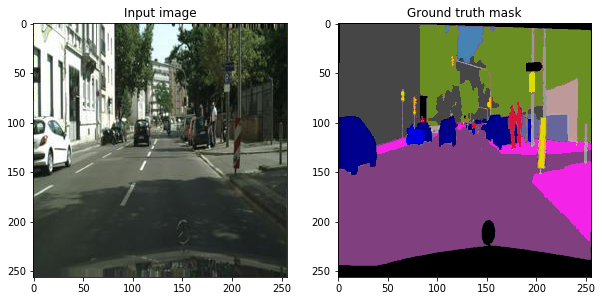

In [27]:
input_img_id = "50"
input_img_filename = input_img_id + "_input.jpg"
ground_truth_filename = input_img_id + "_mask.jpg"

input_img_path = os.path.join("D:\\Projects\\Semantic Segmentation\\Notebooks\\cityscapes_data\\val_input", input_img_filename)
input_img = Image.open(input_img_path).convert("RGB")
input_img = np.array(input_img)

ground_truth_path = os.path.join("D:\\Projects\\Semantic Segmentation\\Notebooks\\cityscapes_data\\val_mask_corrected", ground_truth_filename)
ground_truth = Image.open(ground_truth_path).convert("RGB")
ground_truth = np.array(ground_truth)

fig, axes = plt.subplots(1, 2, figsize = (10,5))
axes[0].title.set_text('Input image')
axes[0].imshow(input_img)
axes[1].title.set_text('Ground truth mask')
axes[1].imshow(ground_truth)

In [28]:
test_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),   
        ],
    )

augmentations = test_transform(image=input_img)
input_img_aug = augmentations["image"]

In [29]:
input_img_aug = input_img_aug.unsqueeze(0)
input_img_aug = input_img_aug.to(device=DEVICE)
print(input_img_aug.shape)

torch.Size([1, 3, 256, 256])


In [30]:
preds = model(input_img_aug)
preds = torch.argmax(preds, dim=1)
preds = preds.to("cpu")
output_img = onehot_to_img(preds[0], color_palette)

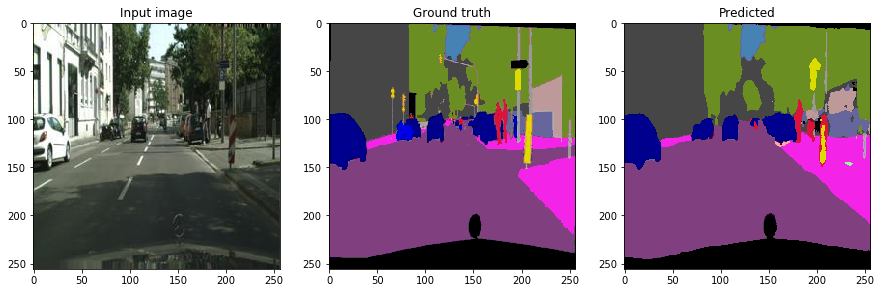

In [31]:
fig, axes = plt.subplots(1, 3, figsize = (15,8))
axes[0].title.set_text('Input image')
axes[0].imshow(input_img)
axes[1].title.set_text('Ground truth')
axes[1].imshow(ground_truth)
axes[2].title.set_text('Predicted')
axes[2].imshow(output_img)

#### Resources
1. How to train a multi-class semantic segmentation algorithm in Pytorch: https://discuss.pytorch.org/t/runtimeerror-only-batches-of-spatial-targets-supported-3d-tensors-but-got-targets-of-dimension-4/82098
2. Why softmax is not required with nn.CrossEntropyLoss(): https://discuss.pytorch.org/t/multi-class-classifier/29901/5